In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import struct
from scipy.signal import butter, filtfilt, firls, iircomb, resample_poly, decimate, envelope, resample

In [2]:
path = 'mediciones_simultaneas/DAVID171225_4-JORGE-20051201024404/bmecg'

with open(path, 'rb') as f:
    raw_data = f.read()

# 1. Parse the Header
# The file starts with "BMECG1" followed by a JSON object
header_start = 6  # Skip "BMECG1"
header_end = raw_data.find(b'}}') + 2
header_json = raw_data[header_start:header_end].decode('utf-8')
header = json.loads(header_json)

print("Header parsed successfully!")
print(f"Sampling Rate: {header['ecg']['samplingRate']} Hz")
print(f"Channels: {header['ecg']['channels']}")

# 2. Find Data Start
# Skip null bytes padding after the JSON header
data_start = header_end
while data_start < len(raw_data) and raw_data[data_start] == 0:
    data_start += 1

print(f"Data starts at byte: {data_start}")

# 3. Read Signal Data
# 'short' format usually means 16-bit signed integer (int16)
num_channels = len(header['ecg']['channels'])
signal_data = np.frombuffer(raw_data, dtype=np.int16, offset=data_start)

# Reshape data: (Samples, Channels)
# We truncate any extra bytes that don't fit perfectly into the shape
num_samples = len(signal_data) // num_channels
signal_data = signal_data[:num_samples * num_channels]
ecg_signal = signal_data.reshape(num_samples, num_channels)
print(f"ECG Signal Shape: {ecg_signal.shape}")
ecg_signal = ecg_signal[:, :12]  # Keep only first 12 channels if more are present

Header parsed successfully!
Sampling Rate: 500 Hz
Channels: ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'CM5', 'CR5']
Data starts at byte: 4096
ECG Signal Shape: (602084, 14)


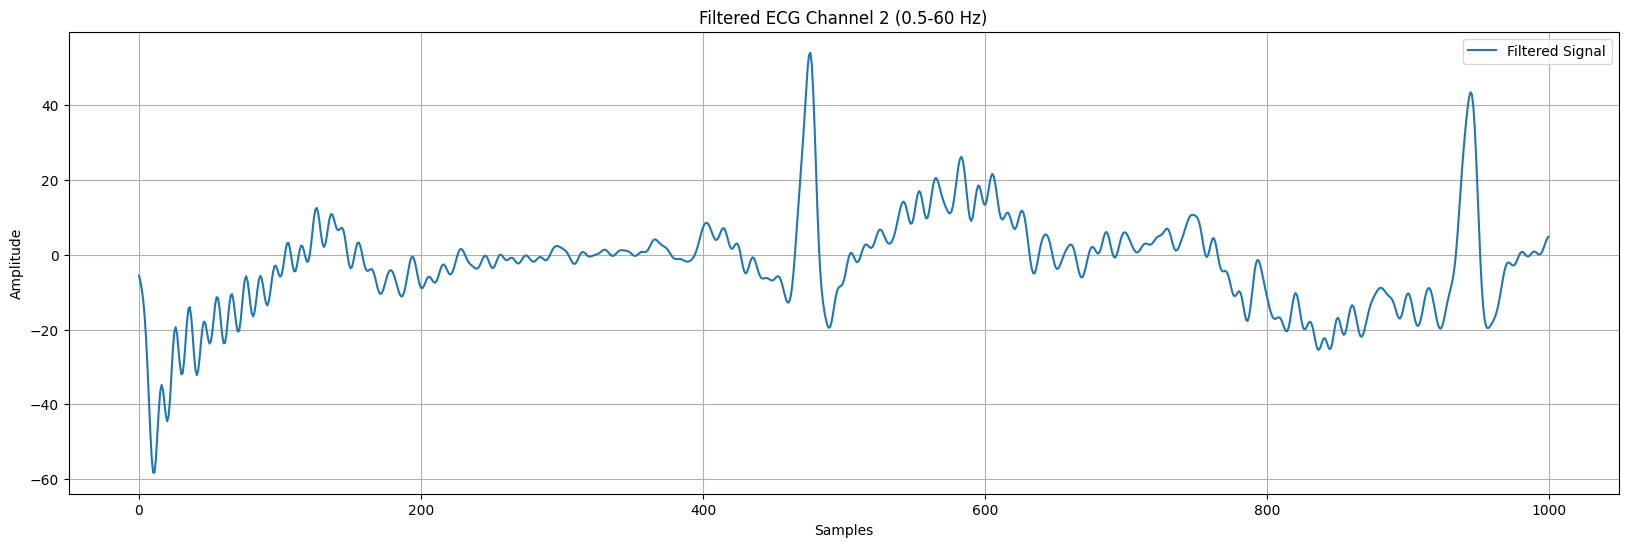

In [3]:
# bandpass filter between 0.5 Hz and 150 Hz for ECG signal channel 2
lowcut = 0.5
highcut = 60.0
fs = header['ecg']['samplingRate']
order = 3
b, a = butter(order, [lowcut, highcut], btype='bandpass', fs=fs)
b2, a2 = butter(order+1, [lowcut, highcut], btype='bandpass', fs=fs)

# comb filter at w0=50 Hz to remove powerline noise
w0 = 50.0  # Frequency to be removed from signal (Hz)
quality_factor = 30.0  # Quality factor
b_notch, a_notch = iircomb(w0, quality_factor, ftype='notch', fs=fs)
ecg_signal = np.array(ecg_signal)
ecg_signal = ecg_signal.astype(np.float32)

ecg_signal = filtfilt(b, a, ecg_signal, axis=0)
ecg_signal = filtfilt(b_notch, a_notch, ecg_signal, axis=0)
ecg_signal = filtfilt(b2, a2, ecg_signal, axis=0)
plt.figure(figsize=(20, 6))
plt.plot(ecg_signal[:1000, 1], label='Filtered Signal')
plt.title('Filtered ECG Channel 2 (0.5-60 Hz)')
plt.grid(True)
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

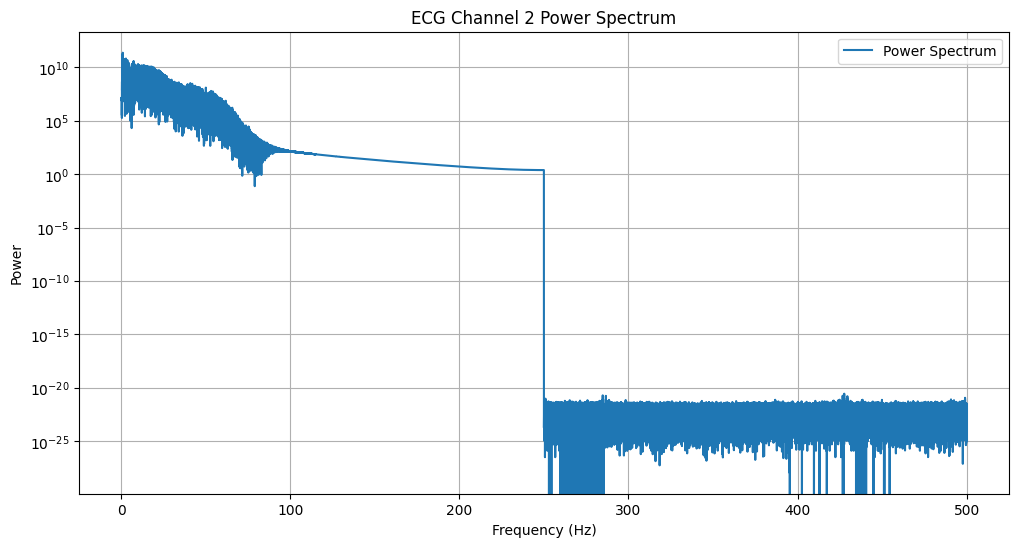

In [4]:
# increase sampling rate to 1000 Hz
ecg_resampled = resample(ecg_signal[:, 1], len(ecg_signal[:, 1]) * 2)
filtered_ecg_fft = np.fft.fft(ecg_resampled)  # FFT of the filtered second channel
freqs = np.linspace(0, header['ecg']['samplingRate'], len(filtered_ecg_fft)//2 + 1)
power_spectrum = np.abs(filtered_ecg_fft[:len(freqs)])**2

plt.figure(figsize=(12, 6))
plt.plot(freqs, power_spectrum[:len(freqs)], label='Power Spectrum')
plt.yscale('log')
plt.grid(True)
plt.title('ECG Channel 2 Power Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.legend()
plt.show()

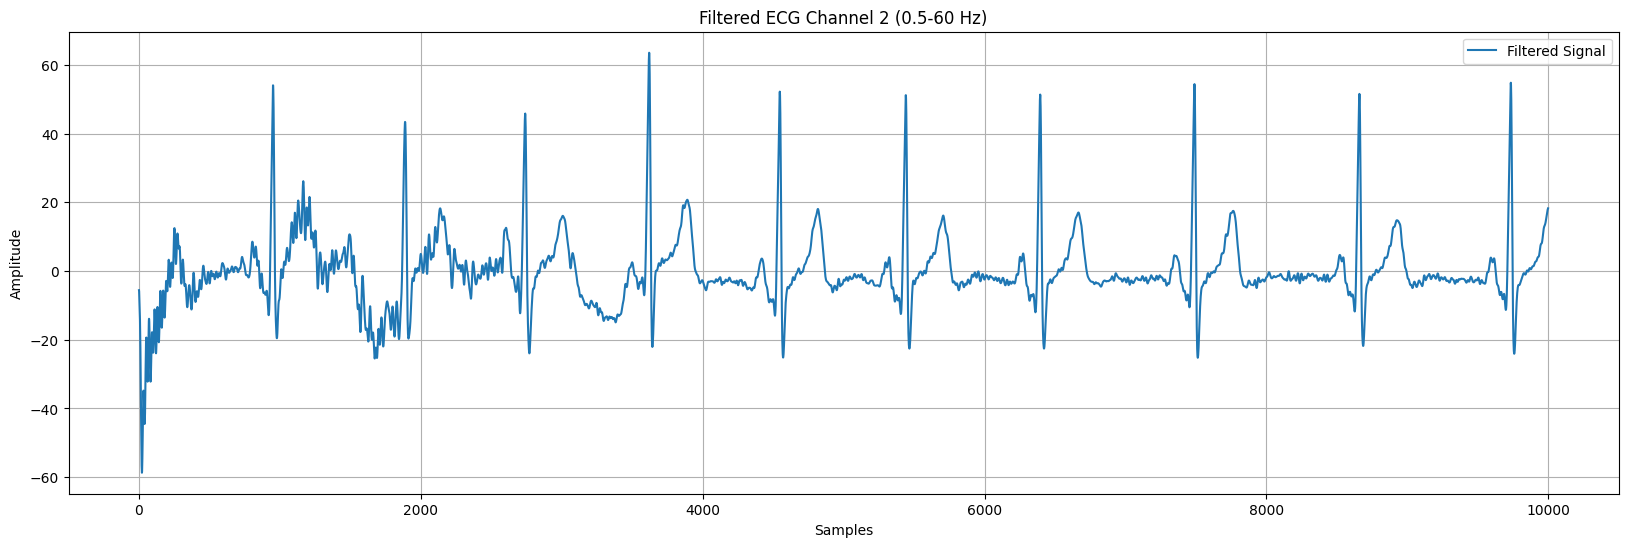

In [5]:
plt.figure(figsize=(20, 6))
plt.plot(ecg_resampled[:10000], label='Filtered Signal')
plt.title('Filtered ECG Channel 2 (0.5-60 Hz)')
plt.grid(True)
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

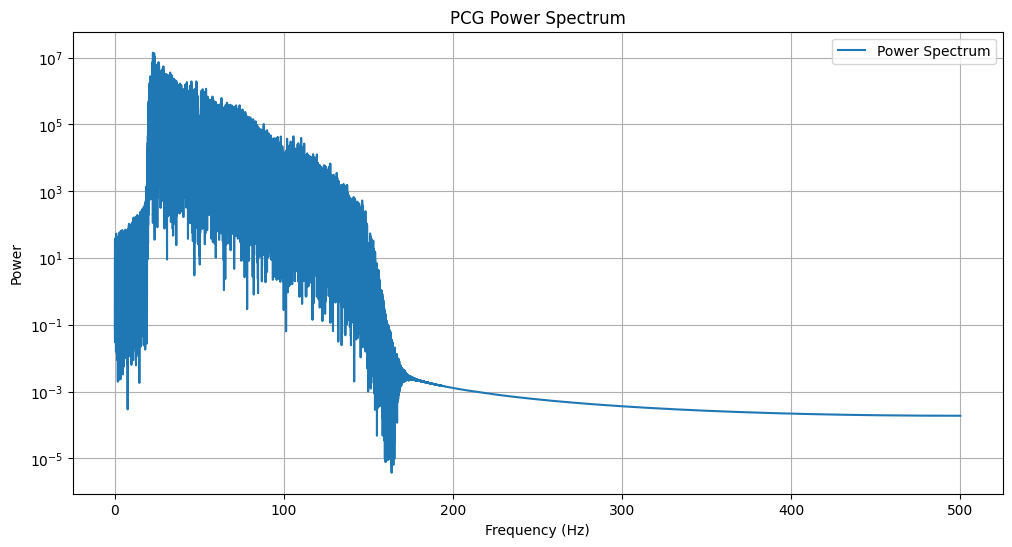

In [6]:
from scipy.io.wavfile import read as wavread

fs, pcg = wavread('mediciones_simultaneas/DAVID171225_4-JORGE-20051201024404/DAVID171225_4_1kHz.wav')
b, a = butter(4, [20.0, 150.0], btype='bandpass', fs=fs)
pcg = filtfilt(b, a, pcg)

b1, a1 = butter(10, [20, 150.0], btype='bandpass', fs=fs)
pcg = filtfilt(b1, a1, pcg)
envol = envelope(pcg, residual=None)

pcg_fft = np.fft.fft(pcg)
freqs = np.linspace(0, fs/2, len(pcg_fft)//2 + 1)
power_spectrum = np.abs(pcg_fft[:len(freqs)])**2

plt.figure(figsize=(12, 6))
plt.plot(freqs, power_spectrum[:len(freqs)], label='Power Spectrum')
plt.yscale('log')
plt.grid(True)
plt.title('PCG Power Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.legend()
plt.show()


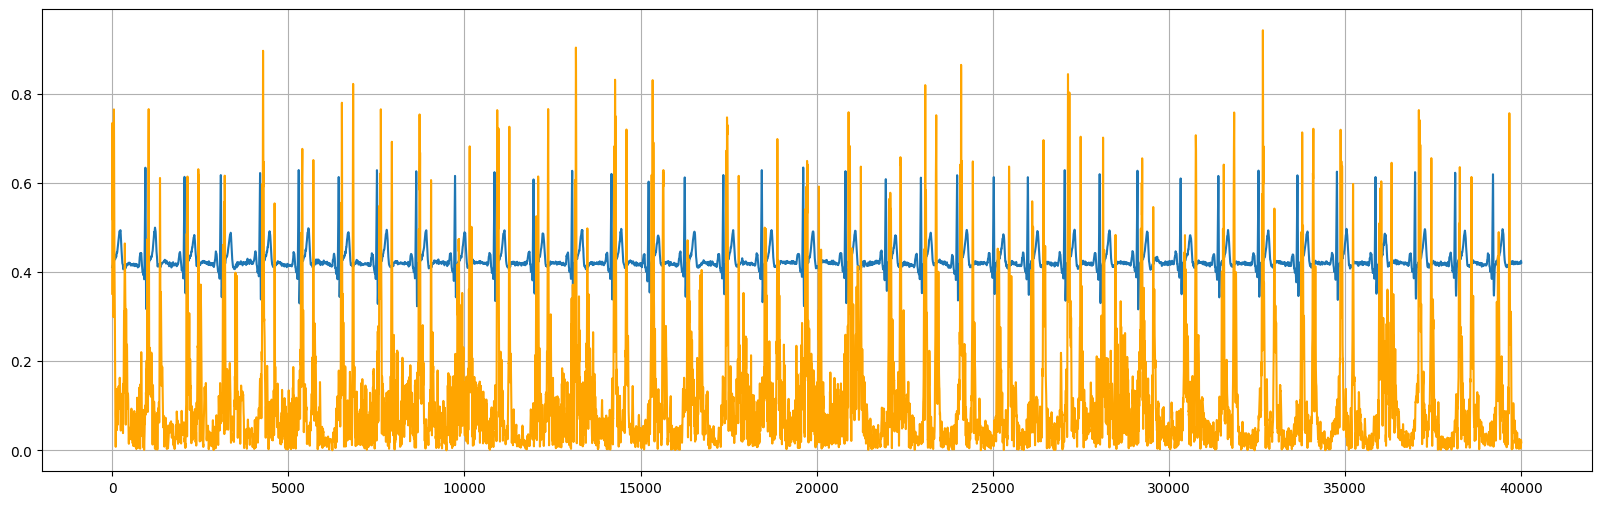

In [80]:
n0 = 50000
n1 = 90000
ecg_normalized = (ecg_resampled - np.min(ecg_resampled)) / (np.max(ecg_resampled) - np.min(ecg_resampled))
envol_normalized = (envol - np.min(envol)) / (np.max(envol) - np.min(envol))
plt.figure(figsize=(20, 6))
plt.plot(ecg_normalized[n0:n1], label='Filtered ECG Channel 2')
plt.plot(envol_normalized[67+n0:67+n1], label='Filtered PCG Signal', color='orange')
plt.grid(True)
#plt.xlim(0, 1030)
plt.show()

In [67]:
np.argmax(ecg_normalized[750:1000]), np.argmax(envol_normalized[1000:1030])

(np.int64(201), np.int64(18))

In [71]:
1018 - (750+201)

67

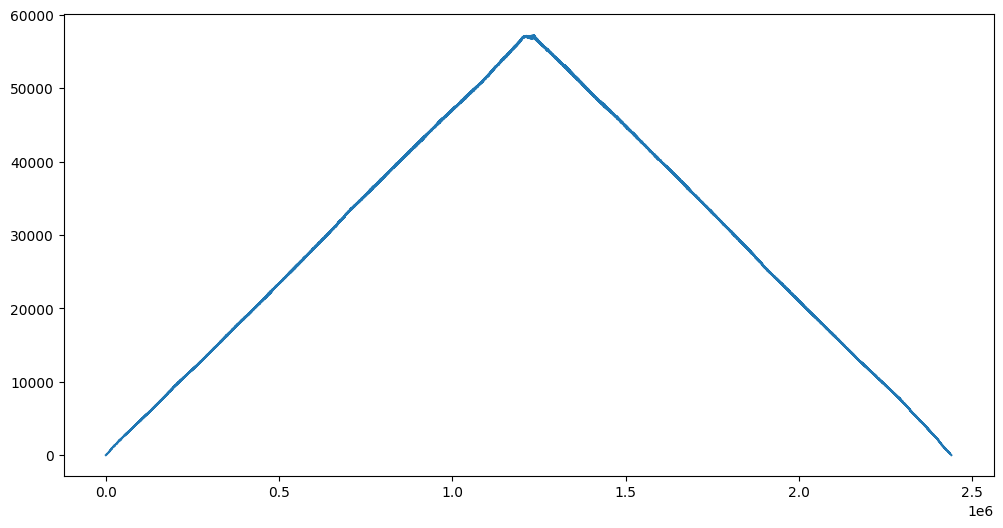

In [58]:
from scipy.signal import correlate
xy_cross = correlate(ecg_normalized, envol_normalized, mode='full', method='fft')
x_axis = np.arange(-len(envol_normalized) + 1, len(ecg_normalized))
plt.figure(figsize=(12, 6))
plt.plot(xy_cross)
# plt.xlim(-50000, 50000)
plt.show()

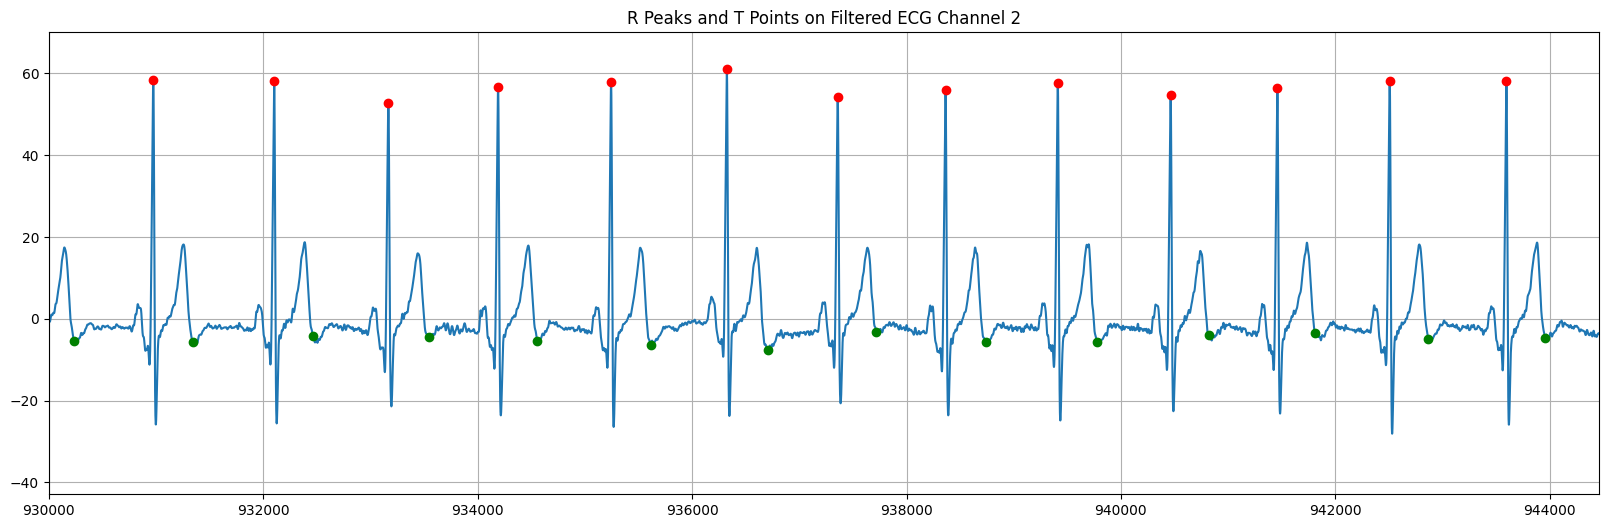

In [67]:
r_peaks = np.loadtxt('mediciones_simultaneas/DAVID171225_2-JORGE-20051201021025/R_marks.txt', dtype=int) * 2 - 272
t_points = np.loadtxt('mediciones_simultaneas/DAVID171225_2-JORGE-20051201021025/T_marks.txt', dtype=int) * 2 - 272
x_axis = np.arange(len(ecg_resampled))

plt.figure(figsize=(20, 6))
plt.plot(ecg_resampled, label='Filtered ECG Channel 2')
plt.plot(x_axis[r_peaks], ecg_resampled[r_peaks], 'ro', label='R Peaks')
plt.plot(x_axis[t_points], ecg_resampled[t_points], 'go', label='T Points')
plt.title('R Peaks and T Points on Filtered ECG Channel 2')
plt.grid(True)
plt.xlim(930000, len(ecg_resampled))
plt.show()

In [66]:
ecg_resampled = ecg_resampled[:t_points[-1]+500]

In [68]:
pcg = pcg[:t_points[-1]+500]

In [71]:
# save new pcg signal as pcg_cutted as a wav file and R marks, T points for training Springer matlab algorithm
from scipy.io.wavfile import write as wavwrite
wavwrite('mediciones_simultaneas/DAVID171225_2-JORGE-20051201021025/pcg_cutted.wav', 1000, pcg.astype(np.float32))

# r_peaks and t_points save as integer arrays in txt files
np.savetxt('mediciones_simultaneas/DAVID171225_2-JORGE-20051201021025/r_peaks.txt', r_peaks, fmt='%d')
np.savetxt('mediciones_simultaneas/DAVID171225_2-JORGE-20051201021025/t_points.txt', t_points, fmt='%d')


In [70]:
type(pcg[1])

numpy.float64